In [243]:
import numpy as np
import matplotlib.pyplot as plt; plt.style.use("fivethirtyeight")
import seaborn as sns
import random
from tqdm import tqdm

from scipy.stats import binom, beta, betabinom

This notebook aims to explore a little bit Metropolis Hastings algorithm based on the following short and easy article:

https://blog.stata.com/2016/11/15/introduction-to-bayesian-statistics-part-2-mcmc-and-the-metropolis-hastings-algorithm/

Let's start with looking at continuous state **Markov Chain** (or Markov Process). In this example we generate a sequence of random variables starting with some random variable $X_0$, and each following distribution is a normal distribution with mean equal to the previous observation: $X_i \sim \mathcal{N}(X_{i-1}, 1)$. Even though it may doesn't seem like it at the beginning, this is obviously Markov Chain: distribution of $X_{i+1}$ depends only on the current state: $X_i$ and we don't need any more history to determine it. This sequence of random variables may also be called a random walk.

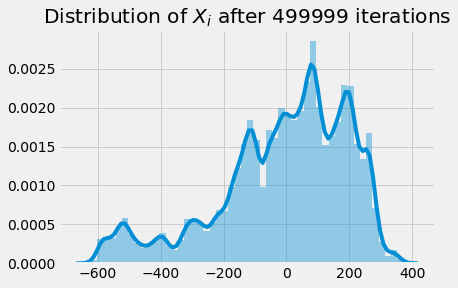

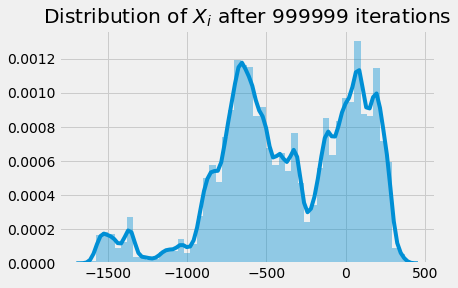

In [244]:
np.random.seed(42)
x = np.random.normal()
data = [x]
for i in range(1_000_000):
    x = np.random.normal(x)
    data.append(x)
    if i % 500_000 == 499_999:
        plt.clf()
        sns.distplot(data)
        plt.title("Distribution of $X_i$ after {} iterations".format(i))
        plt.show()

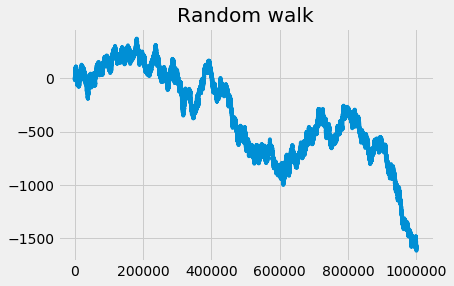

In [245]:
plt.plot(data)
plt.title("Random walk");

## Metropolis Hastings Algorithm Example
Let's consider a coin with some parameter $p$ of getting a head. Let's say that this $p$ is a random variable with a'priori Uniform distribution (each probability between 0 and 1 is equally likely). We are interested in estimating what's the actual value of p given that after 10 throws we got 4 heads. Obviously it's easy to do analytically (well, we don't any math for that), this is just to explain the basics of the algorithm. 

To formalize stuff a little bit: we have 10 samples from distribution $x | p \sim Bern(p)$ (or one observation from $x | p \sim Bern(p)$) , $p \sim Beta(1, 1)$. Because of that, the posterior probability of $p$ is $f(p|x) = \frac{\mathbb{P}(x | p)  f(p)}{\mathbb{P}(x)}$

In [247]:
n = 10

def likelihood(x, p):
    return binom.pmf(n=n, p=p, k=x)

def prior(p):
    return beta.pdf(p, a=1, b=1)  # always equals to one (for 0 <= p <= 1)

In [260]:
x = 4

n_steps = 100_000
sd = 0.01
theta = np.random.normal(0.5, sd)  # this can exceed 1 for many observations (especially if we have millions of samples)
theta_chain = [theta]
for _ in tqdm(range(n_steps)):
    new_theta = np.random.normal(theta, sd)
    posterior_ratio = likelihood(x, new_theta) * prior(new_theta) / (likelihood(x, theta) * prior(theta))
    u = random.random()
    if posterior_ratio >= 1 or u < posterior_ratio:
        theta = new_theta
    theta_chain.append(theta)

100%|██████████| 100000/100000 [01:09<00:00, 1438.52it/s]


In [261]:
np.mean(theta_chain[1_000:]), np.std(theta_chain[1_000:])  # keep in mind that this std doesn't really make sense!

(0.43170786465814437, 0.133365070618379)

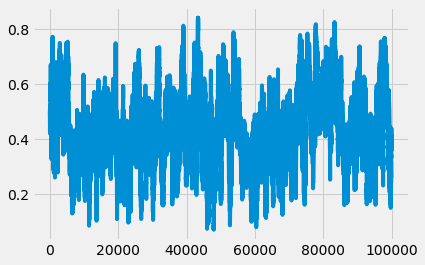

In [262]:
plt.plot(theta_chain)

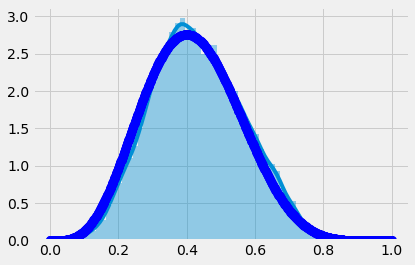

In [263]:
ax = sns.distplot(theta_chain[1_000::3])
a = x + 1
b = n - x + 1
x_ = np.linspace(0, 1, 1000)
ax.plot(x_, beta.pdf(x_, a, b), 'bo', ms=8, label='real posterior distribution')

Besides having just the estimated parameter we have it's probability distribution. But these samples were not independent - in fact they were very much dependent. We could think about taking only one every few samples or getting rid of the beginning (which was biased by the way I chose first variable - it was gaussian with mean 0.5).

But it's worth to keep in mind, that this performance we obtained only after taking 100_000 steps - this code took over one minute to calculate it's results. With 20_000 steps this looks much worse:

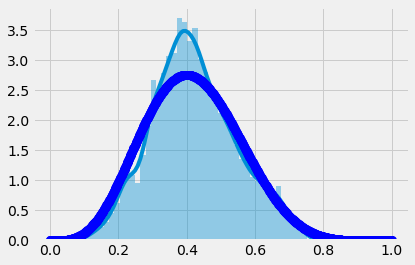

In [264]:
ax = sns.distplot(theta_chain[1_000:20_000:2])
a = x + 1
b = n - x + 1
x_ = np.linspace(0, 1, 1000)
ax.plot(x_, beta.pdf(x_, a, b), 'bo', ms=8, label='real posterior distribution')

This methods seems to works fine, but take a lot of steps to show sensible results. Moreover, it was super simple example just to examine the algorithm. We can imagine, that it will be more difficult to get good results when distributions are much more complex. And the situation when distributions are more complex is exactly the situation when we use Metropolis Hastings. Because of that it would be useful to keep that simple example in mind and think about checking convergence or calculating the error if possible.